<a href="https://colab.research.google.com/github/yeesem/Soft-Computing/blob/main/Class_Activation_Map_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [2]:
import keras
from keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,MaxPooling2D,GlobalAveragePooling2D
import scipy as sp

# Download and Prepare the Data

In [3]:
# Load the Fashion MNIST Dataset
(X_train,Y_train),(X_test,Y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [4]:
# Put an additional axis for the channels of the image
# Fashion MNIST is grayscale so we place 1 at the end
# 3 is placed if it is in RGB
X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)

# Normalize the pixel values from 0 - 1
X_train = X_train/255.0
X_test = X_test/255.0

# Cast to float
X_train = X_train.astype('float')
X_test = X_test.astype('float')

In [5]:
def show_img(img):
  # convert to float array if img is not yet preprocessed
  img = np.array(img,dtype = 'float')

  # remove channel dimension
  img = img.reshape((28,28))

  # Display image
  plt.imshow(img)

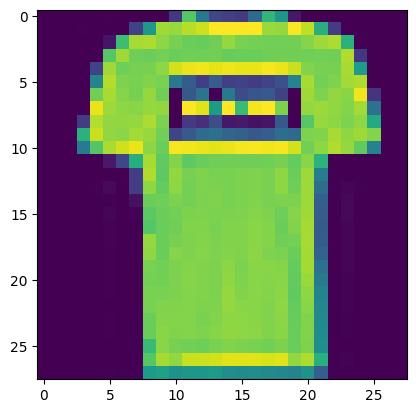

In [6]:
# Test the function for the first train imaeg
show_img(X_train[1])

# Build the Classifier

In [7]:
# Use the Sequential API
model = Sequential()

# Notice the padding parameter to recover the lost border pixels when
# doing the convolution
model.add(Conv2D(16,input_shape = (28,28,1),kernel_size = (3,3),activation = 'relu',padding = 'same'))
# Pooling layer with a stride of 2 will reduce the image dimentions by half
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(32,kernel_size = (3,3),activation = 'relu',padding = 'same'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(64,kernel_size = (3,3),activation = 'relu',padding = 'same'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(128,kernel_size = (3,3),activation = 'relu',padding = 'same'))

# Use global average pooling to take into account lesser intensity pixels
model.add(GlobalAveragePooling2D())

# Output class probabilities
model.add(Dense(10,activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 3, 3, 64)          0

# Train the Model

In [8]:
# Configure the training
model.compile(
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy'],
    optimizer = 'adam'
)

# Train the model
# shuffle=True ensures that your training data is randomly mixed before
# each epoch, which can help improve the performance and generalization of your machine learning model.
model.fit(
    X_train,
    Y_train,
    batch_size = 32,
    epochs = 5,
    validation_split = 0.1,
    shuffle = True
)

Epoch 1/5
1688/1688 [==============================] - 55s 31ms/step - loss: 0.6060 - accuracy: 0.7755 - val_loss: 0.4197 - val_accuracy: 0.8460
Epoch 2/5
1688/1688 [==============================] - 64s 38ms/step - loss: 0.3731 - accuracy: 0.8644 - val_loss: 0.3269 - val_accuracy: 0.8803
Epoch 3/5
1688/1688 [==============================] - 68s 40ms/step - loss: 0.3137 - accuracy: 0.8841 - val_loss: 0.3047 - val_accuracy: 0.8843
Epoch 4/5
1688/1688 [==============================] - 75s 44ms/step - loss: 0.2755 - accuracy: 0.8984 - val_loss: 0.2737 - val_accuracy: 0.9020
Epoch 5/5
1688/1688 [==============================] - 59s 35ms/step - loss: 0.2509 - accuracy: 0.9084 - val_loss: 0.2583 - val_accuracy: 0.9085


# Generate the Class Activation Map

In [9]:
# Final convolution layer
print(model.layers[-3].name)

# global average pooling layer
print(model.layers[-2].name)

# output of the classifier
print(model.layers[-1].name)

conv2d_3
global_average_pooling2d
dense


In [10]:
# Save as previous model but with an additional output
cam_model = Model(inputs = model.input,
                  outputs = (model.layers[-3].output,model.layers[-1].output)
                  )

cam_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496 

In [11]:
# Get the features and results of the test images using the
# newly created model
features,results = cam_model.predict(X_test)

# Shape of the features
print("Features shape : ",features.shape)
print("Results  shape : ",results.shape)

313/313 [==============================] - 3s 9ms/step
Features shape :  (10000, 3, 3, 128)
Results  shape :  (10000, 10)


In [12]:
# these are the weights going into the softmax layer
last_dense_layer = model.layers[-1]

# Get the weights list. index 0 contains the weights, index 1
# contains the biases
gap_weights_l = last_dense_layer.get_weights()

print("gap_weights_l index 0 contains weights ",gap_weights_l[0].shape)
print("gap_weights_l index 1 contains weights ",gap_weights_l[1].shape)

# Show the number of features per class, and the total number of classes
# Store the weights
gap_weights = gap_weights_l[0]

print(f"There are {gap_weights.shape[0]} feature weights and {gap_weights.shape[1]} classes.")

gap_weights_l index 0 contains weights  (128, 10)
gap_weights_l index 1 contains weights  (10,)
There are 128 feature weights and 10 classes.


In [13]:
# Get the features for the image at index 0
idx = 0
features_for_img = features[idx,:,:,:]

print(f"The features for image index {idx} has shape (height,width,num of features channels) : ", features_for_img.shape)

The features for image index 0 has shape (height,width,num of features channels) :  (3, 3, 128)


In [14]:
# if the original dimensions of the image were, for example, (3, 3, 3),
# the new dimensions would be approximately (28, 28, 3).
features_for_img_scaled = sp.ndimage.zoom(
    features_for_img,
    (28/3,28/3,1),
    order = 2
)

print("Features_for_img_scaled up to 28 by 28 height and width : ",features_for_img_scaled.shape)

Features_for_img_scaled up to 28 by 28 height and width :  (28, 28, 128)


In [15]:
# Select the weights that are used for a specific class (0...9)
class_id = 0

# Take the dot product between the scaled image features nd the weights for
gap_weights_for_one_class = gap_weights[:,class_id]

print("feature_for_img_scaled has shape    : ",features_for_img_scaled.shape)
print("gap_weights_for_one_class has shape : ",gap_weights_for_one_class.shape)

cam = np.dot(features_for_img_scaled,gap_weights_for_one_class)

print("clss activation map shape : ",cam.shape)

feature_for_img_scaled has shape    :  (28, 28, 128)
gap_weights_for_one_class has shape :  (128,)
clss activation map shape :  (28, 28)


# Conceptual Interpretation

In [16]:
def show_cam(image_index):
  # Takes the features of the chosen image
  features_for_img = features[image_index,:,:,:]

  # Get the class with the highest output probability
  prediction = np.argmax(results[image_index])

  # Get the gap weights at the predicted class
  class_activation_weights = gap_weights[:,prediction]

  class_activation_features = sp.ndimage.zoom(
      features_for_img,
      (28/3,23/3,1),
      order = 2
  )

  cam_output = np.dot(
      class_activation_features,
      class_activation_weights
  )

  print("Predicted class = ",str(prediction),
        ", Probability = ",str(results[image_index][prediction]))

  plt.imshow(
      np.squeeze((X_test[image_index],-1),alpha = 0.5)
  )

  if results[image_index][prediction] > 0.95:
    camp_str = "Greens"
  else:
    camp_str = "Reds"

  # Overlay the cam output
  plt.imshow(cam_output,camp = camp_str,alpha = 0.5)

  # Display the image
  plt.show()

In [ ]:
def show_maps(desired_class,num_maps):
  counter = 0

  if desired_class < 10:
    print("Please choose a class less than 10")

  # go through the first 10000 images
